In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from phys_ml import metrics
from phys_ml.evaluation import vertex as verteval
from phys_ml.load_data.vertex import *
from phys_ml.trainer import TrainerModes
from phys_ml.trainer.vertex import *
from phys_ml.util import slurm_generate
from phys_ml.visualization import vertex_visualization as vertvis

In [47]:
# latent space
trainer = VertexTrainer(project_name='vertex', config_name='confmod_auto_encoder.json', 
                        subconfig_name='AUTO_ENCODER_VERTEX', 
                        config_kwargs={'path_train': '../frgs'})
ls = trainer.load_latentspace('saves/vertex/save_AUTO_ENCODER_VERTEX_BS20_2024-12-06/version_0')
ls.shape

(576, 576, 128)

### slurm

In [ ]:
# generate slurm
trainer_kwargs = {
    'project_name': 'vertex', 
    'config_name': 'confmod_auto_encoder.json', 
    'subconfig_name': 'AUTO_ENCODER_VERTEX', 
    'config_kwargs': {
        'path_train': '/gpfs/data/fs71925/shepp123/frgs',
        'epochs': 100,
        'subset': 10, 
        'subset_shuffle': True, 
        'subset_seed': 42,
    },
}
slurm_options = slurm_generate.SlurmOptions(qos='zen3_0512_a100x2_devel', time='00:10:00')
slurm_generate.create(project_name='vertex', script_name='vsc_test', 
                      pyenv_dir='/gpfs/data/fs71925/shepp123/anaconda3', slurm_options=slurm_options, 
                      trainer='VertexTrainer', trainer_kwargs=trainer_kwargs)


In [ ]:
# create slurm- and train-script from config-file
!python phys_ml/util/slurm_generate.py configs/confmod_auto_encoder_v2.json

# dev

In [64]:
trainer = VertexTrainer(project_name='vertex', config_name='confmod_auto_encoder.json', 
                        subconfig_name='AUTO_ENCODER_VERTEX', 
                        config_kwargs={'path_train': '../frgs', 'subset': 10, 'subset_shuffle': False})

## Transforming 576^3-matrix to 24^6-matrix

In [77]:
vertex.convert_3d_to_6d_vertex('../frgs')

### Tests

In [1]:
### prepare test matrices
import random
import time
import numpy as np


def print_mat_stats(m):
    print(f'dim: {len(m.shape)}, shape: {m.shape}, size: {m.size}, sum: {m.sum()}')
    #print(m)

random.seed(42)
np.random.seed(42)

n_freq = 24
space_dim = 2
k_dim = 3
dim = space_dim * k_dim
length = n_freq**space_dim

#m576_3 = np.ones((length,) * k_dim)
m576_3 = np.random.rand(*((length,) * k_dim))
m24_6 = np.zeros((n_freq,) * dim)
control_idcs = np.random.randint(0, n_freq, (8, dim))
control_items = [m576_3[idx[0] * n_freq + idx[1], 
                        idx[2] * n_freq + idx[3], 
                        idx[4] * n_freq + idx[5]] for idx in control_idcs]
print_mat_stats(m576_3)
print_mat_stats(m24_6)
print('random control indices:\n', control_idcs)
print('random control items:', control_items)

dim: 3, shape: (576, 576, 576), size: 191102976, sum: 95551209.18438378
dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 0.0
random control indices:
 [[12 11 14  8  5 17]
 [ 6 22  1 20 10  3]
 [15  7 22 10 11  5]
 [12  9  6 11 20 10]
 [ 1 19 18 12  2 13]
 [22 16 11 10  9  9]
 [ 6  0 21 12 11 19]
 [15 12 13 12 15 22]]
random control items: [0.2231108298526705, 0.3851128173293077, 0.7680790819330442, 0.10912941790135045, 0.34650971575367395, 0.8493269356006744, 0.45857532270248447, 0.4882521434863434]


In [2]:
### method 1
t0 = time.time()


def transform_index(i: int) -> tuple[int, int]:
    return (i // n_freq, i % n_freq)


def transform_indices(*indices: int) -> list[int]:
    return [j for i in indices for j in transform_index(i)]


# unpack to 24^6 matrix
m24_6 = np.empty((n_freq,) * dim)
k = np.arange(length)
for i_k1 in range(length):
    for i_k2 in range(length):
        m24_6[*transform_indices(i_k1, i_k2), k // n_freq, k % n_freq] = m576_3[i_k1, i_k2, :]

check_items = [m24_6[*idx] for idx in control_idcs]
print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m24_6)
print('random control items:', check_items == control_items, check_items)


time: 6.784s

dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 95551209.18438378
random control items: True [0.2231108298526705, 0.3851128173293077, 0.7680790819330442, 0.10912941790135045, 0.34650971575367395, 0.8493269356006744, 0.45857532270248447, 0.4882521434863434]


In [3]:
### method 2
t0 = time.time()

m24_6 = np.zeros((n_freq,) * dim)
for i in range(n_freq):
    for j in range(n_freq):
        for k in range(n_freq):
            m24_6[i, :, j, :, k, :] = m576_3[i * n_freq : (i + 1) * n_freq, 
                                             j * n_freq : (j + 1) * n_freq, 
                                             k * n_freq : (k + 1) * n_freq]

check_items = [m24_6[*idx] for idx in control_idcs]
print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m24_6)
print('random control items:', check_items == control_items, check_items)


time: 0.907s

dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 95551209.18438378
random control items: True [0.2231108298526705, 0.3851128173293077, 0.7680790819330442, 0.10912941790135045, 0.34650971575367395, 0.8493269356006744, 0.45857532270248447, 0.4882521434863434]


In [4]:
### method 3
t0 = time.time()

m24_6 = np.zeros((n_freq,) * dim)
for i in range(n_freq):
    for j in range(n_freq):
        m24_6[i, :, j, :, :, :] = m576_3[i * n_freq : (i + 1) * n_freq, 
                                         j * n_freq : (j + 1) * n_freq, 
                                         :].reshape((n_freq,) * 4)

check_items = [m24_6[*idx] for idx in control_idcs]
print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m24_6)
print('random control items:', check_items == control_items, check_items)


time: 0.541s

dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 95551209.18438378
random control items: True [0.2231108298526705, 0.3851128173293077, 0.7680790819330442, 0.10912941790135045, 0.34650971575367395, 0.8493269356006744, 0.45857532270248447, 0.4882521434863434]


In [5]:
### method 4
t0 = time.time()

m24_6 = m576_3.reshape((n_freq,) * dim)

check_items = [m24_6[*idx] for idx in control_idcs]
print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m24_6)
print('random control items:', check_items == control_items, check_items)


time: 0.117s

dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 95551209.18438378
random control items: True [0.2231108298526705, 0.3851128173293077, 0.7680790819330442, 0.10912941790135045, 0.34650971575367395, 0.8493269356006744, 0.45857532270248447, 0.4882521434863434]


In [6]:
### counter check
t0 = time.time()

m24_6 = m576_3.reshape((n_freq,) * dim, order='F')

check_items = [m24_6[*idx] for idx in control_idcs]
print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m24_6)
print('random control items:', np.allclose(check_items, control_items), check_items)


time: 0.000s

dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 95551209.18438378
random control items: False [0.33492172096278894, 0.7445258143299188, 0.7023092181332355, 0.4296937021301115, 0.5976509612927238, 0.47546319469685294, 0.690896655895319, 0.47354879755181545]


In [12]:
# back-conversion
t0 = time.time()

m = m24_6.reshape((length,) * k_dim, order='F')

print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m)
print('element-wise check:', np.allclose(m, m576_3))


time: 0.000s

dim: 3, shape: (576, 576, 576), size: 191102976, sum: 95551209.18438378
random control items: True


# Vertex Autoencoder

## Visualize

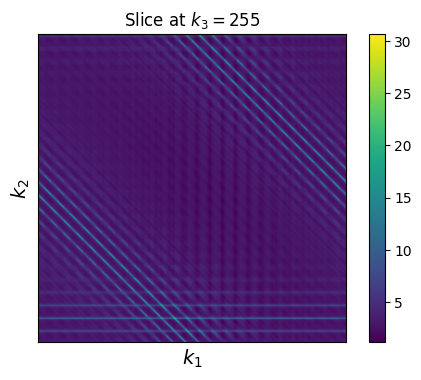

In [146]:
vertex3 = AutoEncoderVertexDataset.load_from_file('../frgs/tp0.020000_mu0.080000.h5')
axis, slice_at = 3, 255
vertvis.plot_section(vertex3, axis, slice_at, figsize=(6,4), title=f'Slice at $k_{axis}={slice_at}$')

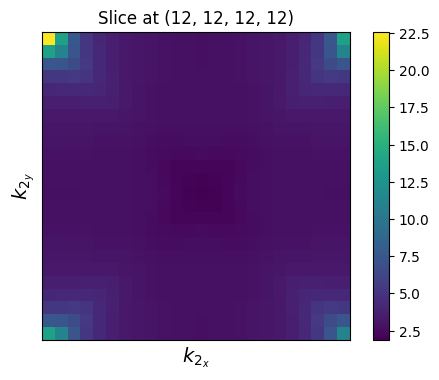

In [147]:
vertex6 = AutoEncoderVertex24x6Dataset.load_from_file('../frgs_6d/tp0.020000_mu0.080000.h5')
i = 12
axis, slice_at = 3, (i, i, i, i)
vertvis.plot_section(vertex6, axis, slice_at, figsize=(6,4), title=f'Slice at {(i, i, i, i)}')

## Training

In [3]:
trainer3 = VertexTrainer(project_name='vertex', config_name='confmod_auto_encoder.json', 
                         subconfig_name='AUTO_ENCODER_VERTEX', 
                         config_kwargs={'path_train': '../frgs', 'subset': 10, 'subset_shuffle': False})

In [3]:
trainer6 = VertexTrainer24x6(project_name='vertex_24x6', config_name='confmod_auto_encoder.json', 
                             subconfig_name='AUTO_ENCODER_VERTEX_24X6', 
                             config_kwargs={'path_train': '../frgs_6d', 
                                            'hidden_dims': [128, 64, 32],
                                            'sample_count_per_vertex': 20000, 
                                            'subset': 2, 'subset_shuffle': False})

In [4]:
trainer6.train(train_mode=TrainerModes.LOCAL)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | AutoEncoderVertex | 32.6 K | train
1 | criterion | MSELoss           | 0      | train
--------------------------------------------------------
32.6 K    Trainable params
0         Non-trainable params
32.6 K    Total params
0.130     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 2400/2400 [00:23<00:00, 101.99it/s, v_num=2, val_loss=0.582]

Epoch 0, global step 2400: 'val_loss' reached 0.58203 (best 0.58203), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=0-step=2400.ckpt' as top 10


Epoch 1: 100%|██████████| 2400/2400 [00:24<00:00, 98.79it/s, v_num=2, val_loss=0.315] 

Epoch 1, global step 4800: 'val_loss' reached 0.31500 (best 0.31500), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=1-step=4800.ckpt' as top 10


Epoch 2: 100%|██████████| 2400/2400 [00:23<00:00, 101.87it/s, v_num=2, val_loss=0.225]

Epoch 2, global step 7200: 'val_loss' reached 0.22501 (best 0.22501), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=2-step=7200.ckpt' as top 10


Epoch 3: 100%|██████████| 2400/2400 [00:23<00:00, 102.82it/s, v_num=2, val_loss=0.164]

Epoch 3, global step 9600: 'val_loss' reached 0.16406 (best 0.16406), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=3-step=9600.ckpt' as top 10


Epoch 4: 100%|██████████| 2400/2400 [00:23<00:00, 101.99it/s, v_num=2, val_loss=0.127]

Epoch 4, global step 12000: 'val_loss' reached 0.12689 (best 0.12689), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=4-step=12000.ckpt' as top 10


Epoch 5: 100%|██████████| 2400/2400 [00:23<00:00, 102.39it/s, v_num=2, val_loss=0.104]

Epoch 5, global step 14400: 'val_loss' reached 0.10441 (best 0.10441), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=5-step=14400.ckpt' as top 10


Epoch 6: 100%|██████████| 2400/2400 [00:23<00:00, 103.39it/s, v_num=2, val_loss=0.0891]

Epoch 6, global step 16800: 'val_loss' reached 0.08908 (best 0.08908), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=6-step=16800.ckpt' as top 10


Epoch 7: 100%|██████████| 2400/2400 [00:23<00:00, 103.90it/s, v_num=2, val_loss=0.076] 

Epoch 7, global step 19200: 'val_loss' reached 0.07597 (best 0.07597), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=7-step=19200.ckpt' as top 10


Epoch 8: 100%|██████████| 2400/2400 [00:23<00:00, 104.21it/s, v_num=2, val_loss=0.0639]

Epoch 8, global step 21600: 'val_loss' reached 0.06390 (best 0.06390), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=8-step=21600.ckpt' as top 10


Epoch 9: 100%|██████████| 2400/2400 [00:23<00:00, 102.18it/s, v_num=2, val_loss=0.0574]

Epoch 9, global step 24000: 'val_loss' reached 0.05738 (best 0.05738), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=9-step=24000.ckpt' as top 10


Epoch 10: 100%|██████████| 2400/2400 [00:23<00:00, 101.60it/s, v_num=2, val_loss=0.0471]

Epoch 10, global step 26400: 'val_loss' reached 0.04710 (best 0.04710), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=10-step=26400.ckpt' as top 10


Epoch 11: 100%|██████████| 2400/2400 [00:23<00:00, 102.79it/s, v_num=2, val_loss=0.0417]

Epoch 11, global step 28800: 'val_loss' reached 0.04169 (best 0.04169), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=11-step=28800.ckpt' as top 10


Epoch 12: 100%|██████████| 2400/2400 [00:23<00:00, 101.98it/s, v_num=2, val_loss=0.0377]

Epoch 12, global step 31200: 'val_loss' reached 0.03770 (best 0.03770), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=12-step=31200.ckpt' as top 10


Epoch 13: 100%|██████████| 2400/2400 [00:23<00:00, 103.22it/s, v_num=2, val_loss=0.0328]

Epoch 13, global step 33600: 'val_loss' reached 0.03276 (best 0.03276), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=13-step=33600.ckpt' as top 10


Epoch 14: 100%|██████████| 2400/2400 [00:23<00:00, 102.10it/s, v_num=2, val_loss=0.0294]

Epoch 14, global step 36000: 'val_loss' reached 0.02940 (best 0.02940), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=14-step=36000.ckpt' as top 10


Epoch 15: 100%|██████████| 2400/2400 [00:23<00:00, 102.78it/s, v_num=2, val_loss=0.0266]

Epoch 15, global step 38400: 'val_loss' reached 0.02657 (best 0.02657), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=15-step=38400.ckpt' as top 10


Epoch 16: 100%|██████████| 2400/2400 [00:23<00:00, 101.81it/s, v_num=2, val_loss=0.0237]

Epoch 16, global step 40800: 'val_loss' reached 0.02367 (best 0.02367), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=16-step=40800.ckpt' as top 10


Epoch 17: 100%|██████████| 2400/2400 [00:23<00:00, 103.13it/s, v_num=2, val_loss=0.0223]

Epoch 17, global step 43200: 'val_loss' reached 0.02228 (best 0.02228), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=17-step=43200.ckpt' as top 10


Epoch 18: 100%|██████████| 2400/2400 [00:23<00:00, 102.66it/s, v_num=2, val_loss=0.0206]

Epoch 18, global step 45600: 'val_loss' reached 0.02061 (best 0.02061), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=18-step=45600.ckpt' as top 10


Epoch 19: 100%|██████████| 2400/2400 [00:23<00:00, 103.13it/s, v_num=2, val_loss=0.0189]

Epoch 19, global step 48000: 'val_loss' reached 0.01890 (best 0.01890), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=19-step=48000.ckpt' as top 10


Epoch 20: 100%|██████████| 2400/2400 [00:23<00:00, 102.27it/s, v_num=2, val_loss=0.0176]

Epoch 20, global step 50400: 'val_loss' reached 0.01757 (best 0.01757), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=20-step=50400.ckpt' as top 10


Epoch 21: 100%|██████████| 2400/2400 [00:23<00:00, 103.49it/s, v_num=2, val_loss=0.0167]

Epoch 21, global step 52800: 'val_loss' reached 0.01667 (best 0.01667), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=21-step=52800.ckpt' as top 10


Epoch 22: 100%|██████████| 2400/2400 [00:23<00:00, 101.66it/s, v_num=2, val_loss=0.0164]

Epoch 22, global step 55200: 'val_loss' reached 0.01642 (best 0.01642), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=22-step=55200.ckpt' as top 10


Epoch 23: 100%|██████████| 2400/2400 [00:23<00:00, 103.64it/s, v_num=2, val_loss=0.0146]

Epoch 23, global step 57600: 'val_loss' reached 0.01462 (best 0.01462), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=23-step=57600.ckpt' as top 10


Epoch 24: 100%|██████████| 2400/2400 [00:23<00:00, 103.34it/s, v_num=2, val_loss=0.0139]

Epoch 24, global step 60000: 'val_loss' reached 0.01386 (best 0.01386), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=24-step=60000.ckpt' as top 10


Epoch 25: 100%|██████████| 2400/2400 [00:23<00:00, 103.54it/s, v_num=2, val_loss=0.0126]

Epoch 25, global step 62400: 'val_loss' reached 0.01261 (best 0.01261), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=25-step=62400.ckpt' as top 10


Epoch 26: 100%|██████████| 2400/2400 [00:23<00:00, 102.34it/s, v_num=2, val_loss=0.0118]

Epoch 26, global step 64800: 'val_loss' reached 0.01180 (best 0.01180), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=26-step=64800.ckpt' as top 10


Epoch 27: 100%|██████████| 2400/2400 [00:23<00:00, 100.34it/s, v_num=2, val_loss=0.011] 

Epoch 27, global step 67200: 'val_loss' reached 0.01102 (best 0.01102), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=27-step=67200.ckpt' as top 10


Epoch 28: 100%|██████████| 2400/2400 [00:23<00:00, 101.11it/s, v_num=2, val_loss=0.0101]

Epoch 28, global step 69600: 'val_loss' reached 0.01013 (best 0.01013), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=28-step=69600.ckpt' as top 10


Epoch 29: 100%|██████████| 2400/2400 [00:23<00:00, 101.77it/s, v_num=2, val_loss=0.011] 

Epoch 29, global step 72000: 'val_loss' reached 0.01097 (best 0.01013), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=29-step=72000.ckpt' as top 10


Epoch 30: 100%|██████████| 2400/2400 [00:23<00:00, 102.30it/s, v_num=2, val_loss=0.00928]

Epoch 30, global step 74400: 'val_loss' reached 0.00928 (best 0.00928), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=30-step=74400.ckpt' as top 10


Epoch 31: 100%|██████████| 2400/2400 [00:23<00:00, 102.57it/s, v_num=2, val_loss=0.00909]

Epoch 31, global step 76800: 'val_loss' reached 0.00909 (best 0.00909), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=31-step=76800.ckpt' as top 10


Epoch 32: 100%|██████████| 2400/2400 [00:23<00:00, 102.29it/s, v_num=2, val_loss=0.00847]

Epoch 32, global step 79200: 'val_loss' reached 0.00847 (best 0.00847), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=32-step=79200.ckpt' as top 10


Epoch 33: 100%|██████████| 2400/2400 [00:23<00:00, 103.09it/s, v_num=2, val_loss=0.00816]

Epoch 33, global step 81600: 'val_loss' reached 0.00816 (best 0.00816), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=33-step=81600.ckpt' as top 10


Epoch 34: 100%|██████████| 2400/2400 [00:23<00:00, 102.70it/s, v_num=2, val_loss=0.00757]

Epoch 34, global step 84000: 'val_loss' reached 0.00757 (best 0.00757), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=34-step=84000.ckpt' as top 10


Epoch 35: 100%|██████████| 2400/2400 [00:23<00:00, 103.26it/s, v_num=2, val_loss=0.00767]

Epoch 35, global step 86400: 'val_loss' reached 0.00767 (best 0.00757), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=35-step=86400.ckpt' as top 10


Epoch 36: 100%|██████████| 2400/2400 [00:23<00:00, 101.85it/s, v_num=2, val_loss=0.00743]

Epoch 36, global step 88800: 'val_loss' reached 0.00743 (best 0.00743), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=36-step=88800.ckpt' as top 10


Epoch 37: 100%|██████████| 2400/2400 [00:23<00:00, 102.77it/s, v_num=2, val_loss=0.00725]

Epoch 37, global step 91200: 'val_loss' reached 0.00725 (best 0.00725), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=37-step=91200.ckpt' as top 10


Epoch 38: 100%|██████████| 2400/2400 [00:23<00:00, 100.78it/s, v_num=2, val_loss=0.00677]

Epoch 38, global step 93600: 'val_loss' reached 0.00677 (best 0.00677), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=38-step=93600.ckpt' as top 10


Epoch 39: 100%|██████████| 2400/2400 [00:23<00:00, 102.02it/s, v_num=2, val_loss=0.00673]

Epoch 39, global step 96000: 'val_loss' reached 0.00673 (best 0.00673), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=39-step=96000.ckpt' as top 10


Epoch 40: 100%|██████████| 2400/2400 [00:23<00:00, 102.63it/s, v_num=2, val_loss=0.00645]

Epoch 40, global step 98400: 'val_loss' reached 0.00645 (best 0.00645), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=40-step=98400.ckpt' as top 10


Epoch 41: 100%|██████████| 2400/2400 [00:23<00:00, 102.05it/s, v_num=2, val_loss=0.00624]

Epoch 41, global step 100800: 'val_loss' reached 0.00624 (best 0.00624), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=41-step=100800.ckpt' as top 10


Epoch 42: 100%|██████████| 2400/2400 [00:23<00:00, 102.79it/s, v_num=2, val_loss=0.00577]

Epoch 42, global step 103200: 'val_loss' reached 0.00577 (best 0.00577), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=42-step=103200.ckpt' as top 10


Epoch 43: 100%|██████████| 2400/2400 [00:23<00:00, 101.88it/s, v_num=2, val_loss=0.00587]

Epoch 43, global step 105600: 'val_loss' reached 0.00587 (best 0.00577), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=43-step=105600.ckpt' as top 10


Epoch 44: 100%|██████████| 2400/2400 [00:23<00:00, 103.29it/s, v_num=2, val_loss=0.0056] 

Epoch 44, global step 108000: 'val_loss' reached 0.00560 (best 0.00560), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=44-step=108000.ckpt' as top 10


Epoch 45: 100%|██████████| 2400/2400 [00:23<00:00, 103.10it/s, v_num=2, val_loss=0.00541]

Epoch 45, global step 110400: 'val_loss' reached 0.00541 (best 0.00541), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=45-step=110400.ckpt' as top 10


Epoch 46: 100%|██████████| 2400/2400 [00:23<00:00, 103.34it/s, v_num=2, val_loss=0.00555]

Epoch 46, global step 112800: 'val_loss' reached 0.00555 (best 0.00541), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=46-step=112800.ckpt' as top 10


Epoch 47: 100%|██████████| 2400/2400 [00:23<00:00, 102.41it/s, v_num=2, val_loss=0.00486]

Epoch 47, global step 115200: 'val_loss' reached 0.00486 (best 0.00486), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=47-step=115200.ckpt' as top 10


Epoch 48: 100%|██████████| 2400/2400 [00:23<00:00, 101.46it/s, v_num=2, val_loss=0.00515]

Epoch 48, global step 117600: 'val_loss' reached 0.00515 (best 0.00486), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=48-step=117600.ckpt' as top 10


Epoch 49: 100%|██████████| 2400/2400 [00:23<00:00, 100.78it/s, v_num=2, val_loss=0.00467]

Epoch 49, global step 120000: 'val_loss' reached 0.00467 (best 0.00467), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=49-step=120000.ckpt' as top 10


Epoch 50: 100%|██████████| 2400/2400 [00:23<00:00, 102.22it/s, v_num=2, val_loss=0.00469]

Epoch 50, global step 122400: 'val_loss' reached 0.00469 (best 0.00467), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=50-step=122400.ckpt' as top 10


Epoch 51: 100%|██████████| 2400/2400 [00:23<00:00, 102.41it/s, v_num=2, val_loss=0.00446]

Epoch 51, global step 124800: 'val_loss' reached 0.00446 (best 0.00446), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=51-step=124800.ckpt' as top 10


Epoch 52: 100%|██████████| 2400/2400 [00:23<00:00, 103.34it/s, v_num=2, val_loss=0.00464]

Epoch 52, global step 127200: 'val_loss' reached 0.00464 (best 0.00446), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=52-step=127200.ckpt' as top 10


Epoch 53: 100%|██████████| 2400/2400 [00:23<00:00, 103.12it/s, v_num=2, val_loss=0.00436]

Epoch 53, global step 129600: 'val_loss' reached 0.00436 (best 0.00436), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=53-step=129600.ckpt' as top 10


Epoch 54: 100%|██████████| 2400/2400 [00:23<00:00, 103.85it/s, v_num=2, val_loss=0.00393]

Epoch 54, global step 132000: 'val_loss' reached 0.00393 (best 0.00393), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=54-step=132000.ckpt' as top 10


Epoch 55: 100%|██████████| 2400/2400 [00:23<00:00, 103.05it/s, v_num=2, val_loss=0.00413]

Epoch 55, global step 134400: 'val_loss' reached 0.00413 (best 0.00393), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=55-step=134400.ckpt' as top 10


Epoch 56: 100%|██████████| 2400/2400 [00:23<00:00, 101.86it/s, v_num=2, val_loss=0.00408]

Epoch 56, global step 136800: 'val_loss' reached 0.00408 (best 0.00393), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=56-step=136800.ckpt' as top 10


Epoch 57: 100%|██████████| 2400/2400 [00:22<00:00, 104.99it/s, v_num=2, val_loss=0.00439]

Epoch 57, global step 139200: 'val_loss' reached 0.00439 (best 0.00393), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=57-step=139200.ckpt' as top 10


Epoch 58: 100%|██████████| 2400/2400 [00:22<00:00, 106.35it/s, v_num=2, val_loss=0.00354]

Epoch 58, global step 141600: 'val_loss' reached 0.00354 (best 0.00354), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=58-step=141600.ckpt' as top 10


Epoch 59: 100%|██████████| 2400/2400 [00:22<00:00, 106.36it/s, v_num=2, val_loss=0.00355]

Epoch 59, global step 144000: 'val_loss' reached 0.00355 (best 0.00354), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=59-step=144000.ckpt' as top 10


Epoch 60: 100%|██████████| 2400/2400 [00:22<00:00, 105.56it/s, v_num=2, val_loss=0.00333]

Epoch 60, global step 146400: 'val_loss' reached 0.00333 (best 0.00333), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=60-step=146400.ckpt' as top 10


Epoch 61: 100%|██████████| 2400/2400 [00:22<00:00, 106.54it/s, v_num=2, val_loss=0.00333]

Epoch 61, global step 148800: 'val_loss' reached 0.00333 (best 0.00333), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=61-step=148800.ckpt' as top 10


Epoch 62: 100%|██████████| 2400/2400 [00:22<00:00, 106.52it/s, v_num=2, val_loss=0.00332]

Epoch 62, global step 151200: 'val_loss' reached 0.00332 (best 0.00332), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=62-step=151200.ckpt' as top 10


Epoch 63: 100%|██████████| 2400/2400 [00:22<00:00, 105.33it/s, v_num=2, val_loss=0.0035] 

Epoch 63, global step 153600: 'val_loss' reached 0.00350 (best 0.00332), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=63-step=153600.ckpt' as top 10


Epoch 64: 100%|██████████| 2400/2400 [00:22<00:00, 106.70it/s, v_num=2, val_loss=0.00358]

Epoch 64, global step 156000: 'val_loss' reached 0.00358 (best 0.00332), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=64-step=156000.ckpt' as top 10


Epoch 65: 100%|██████████| 2400/2400 [00:22<00:00, 105.16it/s, v_num=2, val_loss=0.00301]

Epoch 65, global step 158400: 'val_loss' reached 0.00301 (best 0.00301), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=65-step=158400.ckpt' as top 10


Epoch 66: 100%|██████████| 2400/2400 [00:22<00:00, 106.56it/s, v_num=2, val_loss=0.00384]

Epoch 66, global step 160800: 'val_loss' reached 0.00384 (best 0.00301), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=66-step=160800.ckpt' as top 10


Epoch 67: 100%|██████████| 2400/2400 [00:22<00:00, 106.34it/s, v_num=2, val_loss=0.00334]

Epoch 67, global step 163200: 'val_loss' reached 0.00334 (best 0.00301), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=67-step=163200.ckpt' as top 10


Epoch 68: 100%|██████████| 2400/2400 [00:22<00:00, 106.43it/s, v_num=2, val_loss=0.00319]

Epoch 68, global step 165600: 'val_loss' reached 0.00319 (best 0.00301), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=68-step=165600.ckpt' as top 10


Epoch 69: 100%|██████████| 2400/2400 [00:22<00:00, 105.73it/s, v_num=2, val_loss=0.00289]

Epoch 69, global step 168000: 'val_loss' reached 0.00289 (best 0.00289), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=69-step=168000.ckpt' as top 10


Epoch 70: 100%|██████████| 2400/2400 [00:22<00:00, 105.77it/s, v_num=2, val_loss=0.00281]

Epoch 70, global step 170400: 'val_loss' reached 0.00281 (best 0.00281), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=70-step=170400.ckpt' as top 10


Epoch 71: 100%|██████████| 2400/2400 [00:22<00:00, 105.61it/s, v_num=2, val_loss=0.00264]

Epoch 71, global step 172800: 'val_loss' reached 0.00264 (best 0.00264), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=71-step=172800.ckpt' as top 10


Epoch 72: 100%|██████████| 2400/2400 [00:22<00:00, 106.92it/s, v_num=2, val_loss=0.00311]

Epoch 72, global step 175200: 'val_loss' reached 0.00311 (best 0.00264), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=72-step=175200.ckpt' as top 10


Epoch 73: 100%|██████████| 2400/2400 [00:22<00:00, 105.35it/s, v_num=2, val_loss=0.00257]

Epoch 73, global step 177600: 'val_loss' reached 0.00257 (best 0.00257), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=73-step=177600.ckpt' as top 10


Epoch 74: 100%|██████████| 2400/2400 [00:22<00:00, 106.52it/s, v_num=2, val_loss=0.00282]

Epoch 74, global step 180000: 'val_loss' reached 0.00282 (best 0.00257), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=74-step=180000.ckpt' as top 10


Epoch 75: 100%|██████████| 2400/2400 [00:22<00:00, 105.18it/s, v_num=2, val_loss=0.00298]

Epoch 75, global step 182400: 'val_loss' reached 0.00298 (best 0.00257), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=75-step=182400.ckpt' as top 10


Epoch 76: 100%|██████████| 2400/2400 [00:22<00:00, 106.27it/s, v_num=2, val_loss=0.00282]

Epoch 76, global step 184800: 'val_loss' reached 0.00282 (best 0.00257), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=76-step=184800.ckpt' as top 10


Epoch 77: 100%|██████████| 2400/2400 [00:22<00:00, 105.25it/s, v_num=2, val_loss=0.00252]

Epoch 77, global step 187200: 'val_loss' reached 0.00252 (best 0.00252), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=77-step=187200.ckpt' as top 10


Epoch 78: 100%|██████████| 2400/2400 [00:22<00:00, 106.10it/s, v_num=2, val_loss=0.00254]

Epoch 78, global step 189600: 'val_loss' reached 0.00254 (best 0.00252), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=78-step=189600.ckpt' as top 10


Epoch 79: 100%|██████████| 2400/2400 [00:23<00:00, 100.10it/s, v_num=2, val_loss=0.0026] 

Epoch 79, global step 192000: 'val_loss' reached 0.00260 (best 0.00252), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=79-step=192000.ckpt' as top 10


Epoch 80: 100%|██████████| 2400/2400 [00:23<00:00, 101.98it/s, v_num=2, val_loss=0.00234]

Epoch 80, global step 194400: 'val_loss' reached 0.00234 (best 0.00234), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=80-step=194400.ckpt' as top 10


Epoch 81: 100%|██████████| 2400/2400 [00:23<00:00, 102.07it/s, v_num=2, val_loss=0.00229]

Epoch 81, global step 196800: 'val_loss' reached 0.00229 (best 0.00229), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=81-step=196800.ckpt' as top 10


Epoch 82: 100%|██████████| 2400/2400 [00:23<00:00, 103.03it/s, v_num=2, val_loss=0.00245]

Epoch 82, global step 199200: 'val_loss' reached 0.00245 (best 0.00229), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=82-step=199200.ckpt' as top 10


Epoch 83: 100%|██████████| 2400/2400 [00:23<00:00, 102.13it/s, v_num=2, val_loss=0.00247]

Epoch 83, global step 201600: 'val_loss' reached 0.00247 (best 0.00229), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=83-step=201600.ckpt' as top 10


Epoch 84: 100%|██████████| 2400/2400 [00:23<00:00, 102.96it/s, v_num=2, val_loss=0.0022] 

Epoch 84, global step 204000: 'val_loss' reached 0.00220 (best 0.00220), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=84-step=204000.ckpt' as top 10


Epoch 85: 100%|██████████| 2400/2400 [00:23<00:00, 102.31it/s, v_num=2, val_loss=0.00222]

Epoch 85, global step 206400: 'val_loss' reached 0.00222 (best 0.00220), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=85-step=206400.ckpt' as top 10


Epoch 86: 100%|██████████| 2400/2400 [00:23<00:00, 102.87it/s, v_num=2, val_loss=0.00239]

Epoch 86, global step 208800: 'val_loss' reached 0.00239 (best 0.00220), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=86-step=208800.ckpt' as top 10


Epoch 87: 100%|██████████| 2400/2400 [00:23<00:00, 101.61it/s, v_num=2, val_loss=0.00216]

Epoch 87, global step 211200: 'val_loss' reached 0.00216 (best 0.00216), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=87-step=211200.ckpt' as top 10


Epoch 88: 100%|██████████| 2400/2400 [00:23<00:00, 101.78it/s, v_num=2, val_loss=0.00213]

Epoch 88, global step 213600: 'val_loss' reached 0.00213 (best 0.00213), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=88-step=213600.ckpt' as top 10


Epoch 89: 100%|██████████| 2400/2400 [00:23<00:00, 100.16it/s, v_num=2, val_loss=0.00223]

Epoch 89, global step 216000: 'val_loss' reached 0.00223 (best 0.00213), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=89-step=216000.ckpt' as top 10


Epoch 90: 100%|██████████| 2400/2400 [00:22<00:00, 104.67it/s, v_num=2, val_loss=0.00213]

Epoch 90, global step 218400: 'val_loss' reached 0.00213 (best 0.00213), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=90-step=218400.ckpt' as top 10


Epoch 91: 100%|██████████| 2400/2400 [00:23<00:00, 103.62it/s, v_num=2, val_loss=0.00249]

Epoch 91, global step 220800: 'val_loss' was not in top 10


Epoch 92: 100%|██████████| 2400/2400 [00:23<00:00, 104.32it/s, v_num=2, val_loss=0.0021] 

Epoch 92, global step 223200: 'val_loss' reached 0.00210 (best 0.00210), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=92-step=223200.ckpt' as top 10


Epoch 93: 100%|██████████| 2400/2400 [00:22<00:00, 105.23it/s, v_num=2, val_loss=0.00208]

Epoch 93, global step 225600: 'val_loss' reached 0.00208 (best 0.00208), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=93-step=225600.ckpt' as top 10


Epoch 94: 100%|██████████| 2400/2400 [00:23<00:00, 103.64it/s, v_num=2, val_loss=0.00237]

Epoch 94, global step 228000: 'val_loss' was not in top 10


Epoch 95: 100%|██████████| 2400/2400 [00:22<00:00, 105.12it/s, v_num=2, val_loss=0.0019] 

Epoch 95, global step 230400: 'val_loss' reached 0.00190 (best 0.00190), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=95-step=230400.ckpt' as top 10


Epoch 96: 100%|██████████| 2400/2400 [00:22<00:00, 104.92it/s, v_num=2, val_loss=0.00201]

Epoch 96, global step 232800: 'val_loss' reached 0.00201 (best 0.00190), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=96-step=232800.ckpt' as top 10


Epoch 97: 100%|██████████| 2400/2400 [00:23<00:00, 103.30it/s, v_num=2, val_loss=0.00261]

Epoch 97, global step 235200: 'val_loss' was not in top 10


Epoch 98: 100%|██████████| 2400/2400 [00:22<00:00, 105.04it/s, v_num=2, val_loss=0.00188]

Epoch 98, global step 237600: 'val_loss' reached 0.00188 (best 0.00188), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-12\\version_2\\checkpoints\\epoch=98-step=237600.ckpt' as top 10


Epoch 99: 100%|██████████| 2400/2400 [00:22<00:00, 104.66it/s, v_num=2, val_loss=0.00225]

Epoch 99, global step 240000: 'val_loss' was not in top 10
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2400/2400 [00:22<00:00, 104.64it/s, v_num=2, val_loss=0.00225]


In [ ]:
%load_ext tensorboard
%tensorboard --logdir saves

## Predict

In [4]:
test_file = 'tp0.020000_mu0.080000.h5'
test_file3d = '../frgs/' + test_file
test_file6d = '../frgs_6d/' + test_file

save_path6d = 'save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-11/version_2'
save_path3d = 'save_AUTO_ENCODER_VERTEX_BS20_2024-12-06/version_0'

In [ ]:
vertex3 = AutoEncoderVertexDataset.load_from_file(test_file3d)
vertex6 = AutoEncoderVertex24x6Dataset.load_from_file(test_file6d)

In [5]:
def rmse(target: np.ndarray, pred: np.ndarray) -> float:
    return np.sqrt(np.square(target - pred).mean())

### 6D matrix

In [17]:
pred6 = trainer6.predict(test_file6d, new_vertex=vertex6, save_path=save_path6d)
pred6.shape

100%|██████████| 7962624/7962624 [48:02<00:00, 2762.56it/s]


(24, 24, 24, 24, 24, 24)

In [10]:
pred6 = trainer6.load_prediction(save_path='save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23/version_0')
pred6.shape

(24, 24, 24, 24, 24, 24)

In [15]:
reconstr6 = trainer6.dataset.to_3d_vertex(pred6)
reconstr6.shape

(576, 576, 576)

In [27]:
ls6 = trainer6.predict(test_file6d, new_vertex=vertex6, save_path=save_path6d, encode_only=True)
ls6.shape

 >>> Load checkpoint from 'c:/OneDrive - TU Wien/Studium/Master_5. Semester/Masters thesis/code/LuttingerWard_from_ML/saves/vertex_24x6/save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\version_1\checkpoints\epoch=99-step=24000.ckpt'


(576, 576, 32)

In [21]:
control_idcs = np.random.randint(0, 24, (8, 6))
control_items = [vertex6[*idx] for idx in control_idcs]
print('random control items:\n', [round(ci, 3) for ci in control_items])

random control items:
 [3.393, 5.831, 2.709, 3.065, 2.728, 2.89, 3.02, 2.564]


In [22]:
check_items = [pred6[*idx] for idx in control_idcs]
print('random control items:\n', [round(ci, 3) for ci in check_items])

random control items:
 [3.509, 2.47, 2.675, 2.744, 2.918, 2.641, 2.861, 2.887]


2.1074274429563444

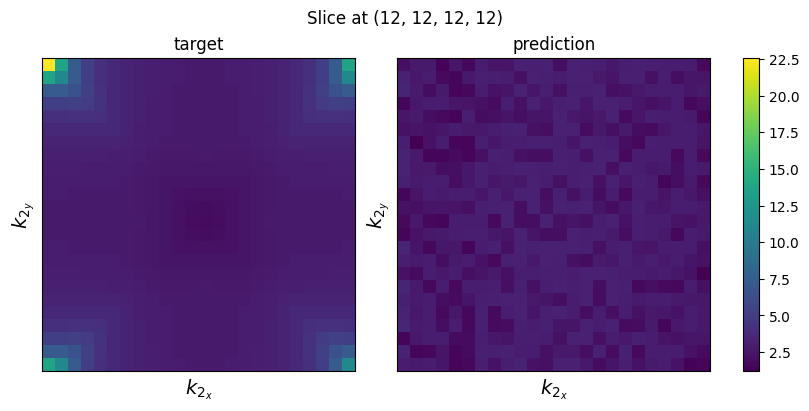

In [ ]:
i = 12
axis, slice_at = 3, (i, i, i, i)
vertvis.plot_compare(vertex6, pred6, axis, slice_at, figsize=(10,4), title=f'Slice at {(i, i, i, i)}')
rmse(vertex6, pred6)

2.1074274429563435

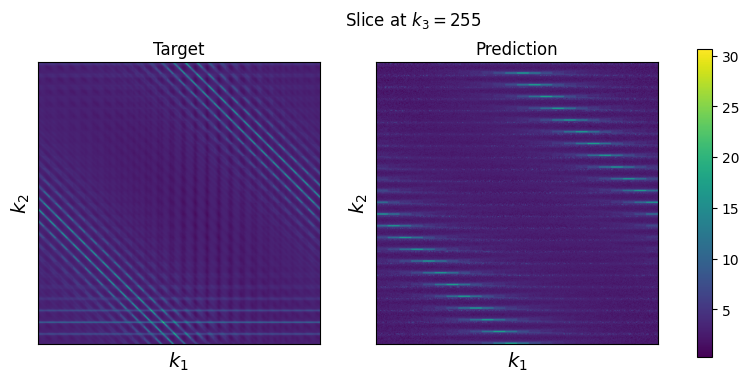

In [152]:
axis, slice_at = 3, 255
vertvis.plot_compare(vertex3, reconstr6, axis, slice_at, figsize=(10,4), title=f'Slice at $k_{axis}={slice_at}$')
rmse(vertex3, reconstr6)

### 6D matrix: single 2D slice

 >>> Load checkpoint from 'c:/OneDrive - TU Wien/Studium/Master_5. Semester/Masters thesis/code/PhysML/saves/vertex_24x6/save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-11/version_2\checkpoints\epoch=99-step=40000.ckpt'


100%|██████████| 24/24 [00:00<00:00, 2667.28it/s]

(24, 24)


0.18177693287945806

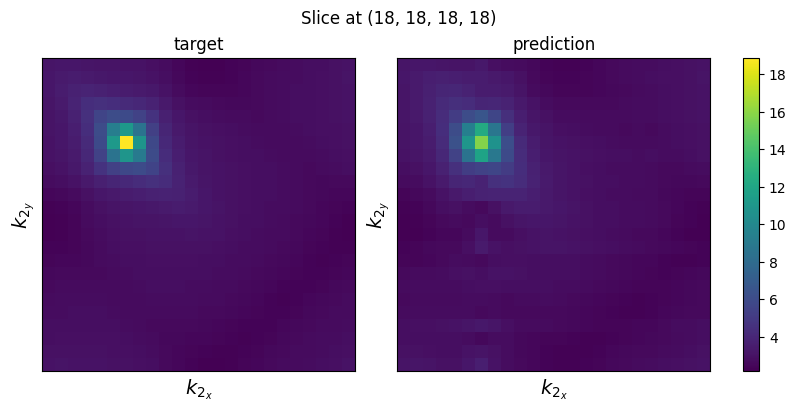

In [18]:
i = 18
axis, slice_at = 3, (i, i, i, i)

pred_slice = trainer6.predict_slice2d(test_file6d, new_vertex=vertex6, save_path=save_path6d, kix=i, kiy=i, kjx=i, kjy=i)
print(pred_slice.shape)

vertvis.plot_compare(vertex6, pred_slice, axis, slice_at, figsize=(10,4), title=f'Slice at {slice_at}')
rmse(vertex6[i, i, :, :, i, i], pred_slice)

### 6D matrix: single 4D slice

In [30]:
import numpy as np

def pl(data: np.ndarray, axis: int, figsize: tuple[int, int] = (14,6), vmin: float = None, vmax: float = None):
    max_value = np.max(data)
    fig, ax, max_value = vertvis._init_plot(data, figsize)
    img = vertvis._create_slice_plot(ax, data, None, axis, max_value, vmin=vmin, vmax=vmax)
    fig.colorbar(img, ax=ax)

 >>> Load checkpoint from 'c:/OneDrive - TU Wien/Studium/Master_5. Semester/Masters thesis/code/PhysML/saves/vertex_24x6/save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-11/version_2\checkpoints\epoch=99-step=40000.ckpt'


100%|██████████| 13824/13824 [00:05<00:00, 2755.57it/s]


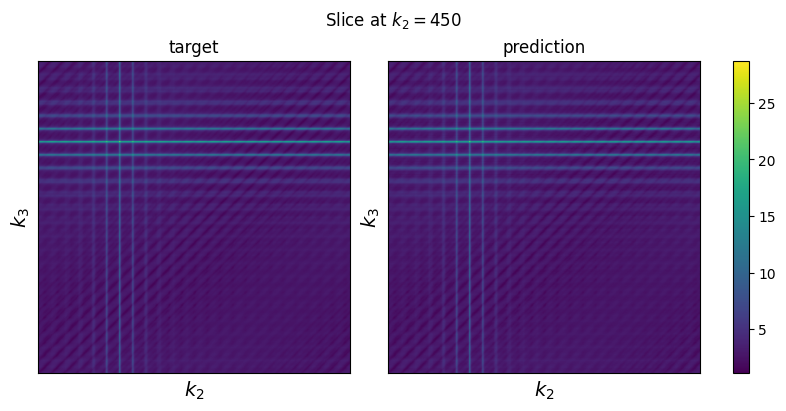

In [ ]:
i = 18
axis, slice_at = 3, (i, i)
k, other_k = (axis + 1) // 2, 3
pred_slice = trainer6.predict_slice4d(test_file6d, new_vertex=vertex6, save_path=save_path6d, kix=i, kiy=i, other_k=other_k)

vertvis.plot_compare(vertex3, pred_slice, axis=(k, other_k), slice_at=slice_at, figsize=(10,4), 
                     title=f'Slice at $k_{k}={slice_at[0] * 24 + slice_at[1]}$')

In [ ]:
plot_data = {'original': vertex3, '1': pred_slice, '2': pred_slice, '3': pred_slice}
vertvis.plot_compare_grid(plot_data, 2, 2, axis=(k, other_k), slice_at=slice_at, figsize=(10, 8))

In [ ]:
error_data = {k: np.abs(v - vertex3) for k, v in plot_data.items()}
vertvis.plot_compare_grid(error_data, 2, 2, axis=(k, other_k), slice_at=slice_at, figsize=(10, 8))

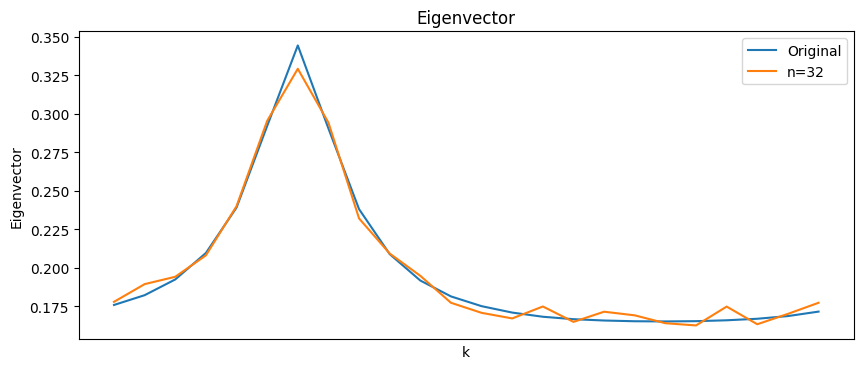

In [61]:
p_evec = metrics.vertex.get_dominant_eigenvector(pred_slice)
t_evec = metrics.vertex.get_dominant_eigenvector(target_slice)

vertvis.lineplot_compare(dict({32: p_evec}), target=t_evec, title='Eigenvector', ylabel='Eigenvector', 
                         label_func=lambda x: f'n={x}', xticks=[], xlabel='k')

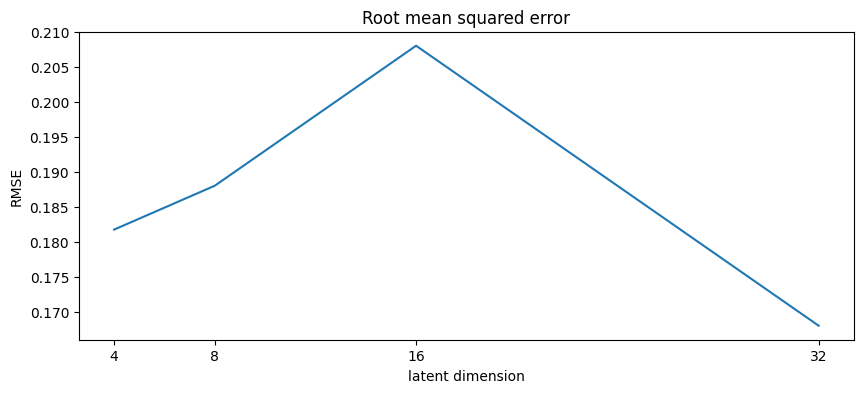

In [55]:
vertvis.lineplot([x], [y], title='Root mean squared error', ylabel='RMSE', xlabel='latent dimension', xticks=x)

### 3D matrix

In [16]:
reconstr3 = trainer3.predict(test_file3d, new_vertex=vertex3, save_path=save_path3d)
reconstr3.shape

 >>> Load checkpoint from 'c:/OneDrive - TU Wien/Studium/Master_5. Semester/Masters thesis/code/LuttingerWard_from_ML/saves/vertex_v2/save_AUTO_ENCODER_VERTEX_V2_BS20_2024-12-06\version_0\checkpoints\epoch=99-step=24000.ckpt'


100%|██████████| 331776/331776 [10:15<00:00, 539.08it/s]


(576, 576, 576)

In [ ]:
ls3 = trainer3.predict(test_file3d, new_vertex=vertex3, save_path=save_path3d, encode_only=True)
ls3.shape

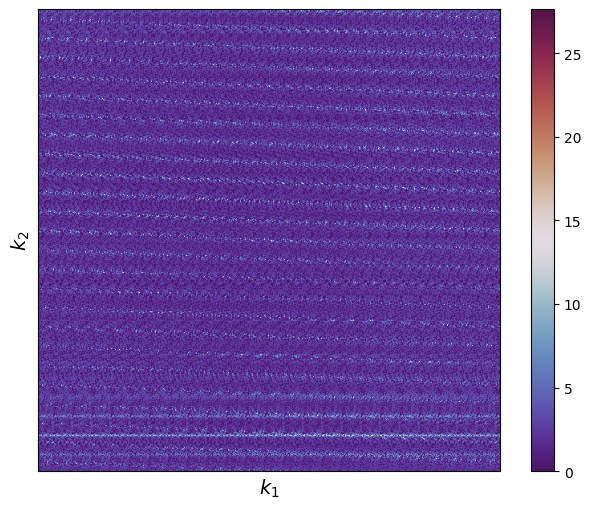

In [13]:
vertvis.plot_compare(vertex3, reconstr3, axis=3, slice_at=255, figsize=(10,4))

## Evaluate

In [56]:
import numpy as np


In [84]:
# vertex reconstruction error
def reconstr_err(target: np.ndarray, pred: np.ndarray) -> float:
    return np.linalg.norm(pred - vertex) / np.linalg.norm(target)

recerr = reconstr_err(vertex, pred)
recerr

0.06782501212528207

In [ ]:
# eigenvalue reconstruction errors


eigenvalues, eigenvectors = np.linalg.eig(pred[:,:,0])
len(eigenvalues)

In [93]:
et, _ = np.linalg.eig(vertex[:,:,0])
ep, _ = np.linalg.eig(pred[:,:,0])
sorted(abs(et) - abs(ep))

[-16.603054854308738,
 -8.73705845531866,
 -6.047905939013205,
 -5.096497126487918,
 -4.0603994020076755,
 -3.437334866358647,
 -3.4278187822464403,
 -3.396372196458799,
 -3.3677542824526583,
 -2.8505365006967516,
 -2.823668178241393,
 -2.8217525135441406,
 -2.6220673415432216,
 -2.4426288425095706,
 -2.3578484465369183,
 -2.3027480266967224,
 -2.2220143601956255,
 -2.200687548866185,
 -2.1428611410338156,
 -2.1214966658602097,
 -2.0693617041357992,
 -2.023019165582013,
 -1.9820313497249349,
 -1.9265533934335526,
 -1.7446407141738831,
 -1.6362894411267455,
 -1.5986066074324925,
 -1.5238116025273243,
 -1.4974563263754108,
 -1.451441388232099,
 -1.4483221780295676,
 -1.392246150392741,
 -1.3918965853533534,
 -1.3913931561715165,
 -1.3838159191858055,
 -1.3612311033962579,
 -1.3535136655474256,
 -1.3535136655474256,
 -1.34155205642592,
 -1.3310056687461826,
 -1.3182741598726508,
 -1.3171121870598337,
 -1.304480888013221,
 -1.2270809972396535,
 -1.219796161835884,
 -1.1941885105421308,
 -1

In [ ]:
# -> different for different sections
v1, _ = np.linalg.eig(pred[:,:,2])
v2, _ = np.linalg.eig(pred[:,:,167])
sorted(abs(v1) - abs(v2))

[-5.159774691615382,
 -5.159774691615382,
 -2.670358603649456,
 -2.6452022895458676,
 -2.5365652374371646,
 -2.5365652374371646,
 -2.1973631753281104,
 -1.7622380593573803,
 -1.7145238676950103,
 -1.7145238676950103,
 -1.311740927100895,
 -1.311740927100895,
 -1.2613336869798286,
 -1.2431897554938165,
 -1.2431897554938165,
 -1.2282179235558845,
 -1.224065307041875,
 -1.1832460134965346,
 -1.1832460134965346,
 -1.1791063429646211,
 -1.1791063429646211,
 -1.1762217297304596,
 -1.1762217297304596,
 -1.1660999242415686,
 -1.1200112784989842,
 -1.06492727661748,
 -1.0227705531644466,
 -0.9889097686528343,
 -0.9781178504381902,
 -0.8937074027219114,
 -0.8710658920033509,
 -0.8172803314982096,
 -0.723009973726648,
 -0.6963801310527509,
 -0.6883332648033775,
 -0.6883332648033775,
 -0.6579163662863117,
 -0.5928350208042978,
 -0.5738081907704013,
 -0.5738081907704013,
 -0.5694149003925997,
 -0.5128420527715569,
 -0.49820122265309585,
 -0.48083723367562836,
 -0.4739914493171584,
 -0.4667365511272

In [73]:
# RMSE
def rmse(target: np.ndarray, pred: np.ndarray) -> float:
    return np.sqrt(np.square(target - pred).mean())

rmse_ = rmse(vertex, pred)
rmse_

0.2557820921515644

In [71]:
# relative errors
def rel_error(target: np.ndarray, pred: np.ndarray) -> float:
    return np.average(np.divide(np.abs(target - pred), np.abs(target)))

relerr = rel_error(vertex, pred)
relerr

0.045636286180477006

In [ ]:
# dimension compression rate
import math
from src.trainer import BaseTrainer

def compression_rate(trainer: BaseTrainer) -> float:
    in_dim = trainer.get_input_size()
    if not isinstance(in_dim, int):
        hidden = [math.prod(d) for d in trainer.config.hidden_dims]
        return min(hidden) / math.prod(in_dim)
    else:
        return min(trainer.config.hidden_dims) / in_dim

compr = compression_rate(trainer)
compr

0.07407407407407407